In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def transformation(Y):
    l=[]
    n = 0
    for y in Y:
        if y =='TLS':
            n = n+1
            l.append(1)
        else:
            l.append(0)
    print(n)
    return np.array(l)
def count(Y):
    n = 0
    for y in Y:
        if y ==1:
            n = n+1
    print(n)

### 1. load dataset

In [9]:
sample = ["a_3","b_1","b_18"]
X_list = []
y_list = []
Gene = []
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#load data
for i in range(len(sample)):
    #load Y
    path = 'result/'+sample[i]+'_annotation.csv'
    data = pd.read_csv(path)
    c = data.shape[0]
    #load X
    path = "result/"+sample[i]+"_matrix.csv"
    X_data = pd.read_csv(path)
    l_gene = X_data["Unnamed: 0"]
    Gene.append(l_gene)
    #Adjust the barcode for X
    bar = X_data.columns[1:]
    l_bar=[]
    for j in bar:
        j=str(j).replace("X","")
        l_bar.append(j)
    a = X_data.shape[0]
    b = X_data.shape[1]-1
    X_data = np.array(X_data[bar])
    #normalization
    X_scaler = scaler.fit(X_data)                                   
    X_data = X_scaler.transform(X_data)
    #reconstruct X
    X_data = pd.DataFrame(X_data.T, columns = l_gene, index = l_bar)
    #recorde X
    X_list.append(X_data)
    D1 = dict()
    key = []
    #adjust the barcode for y
    for l in range(c):
        x = '-'+str(i)
        key1 = data['Unnamed: 0'][l]
        value1 = data['TLS_2_cat_annot'][l]
        key1 = str(key1).replace('-1','.1')
        key.append(key1)
        D1[key1] = value1
    L1 = list()
    for j in l_bar:
        if j in key:
            tls = D1[j]
        else:
            tls = 'NO_TLS'
        L1.append(tls)
    #transform to 0,1
    y_data = transformation(L1)
    y_data = y_data.ravel()
    #recorde y
    y_list.append(y_data)
    

33
153
78


### 2.Integration of dataset

In [10]:
#identify the genes shared by all the training samples
intersection=[]
for i in range(len(Gene)):
    if i==0:
        intersection=set(Gene[i])
    else:
        intersection=set(intersection).intersection(set(Gene[i]))
        
#merge the samples to construct the training dataset        
for i in range(len(sample)):
    X_data=X_list[i]
    y_data=y_list[i]
    X_data=X_data[intersection]
    X_data = np.array(X_data).tolist()
    y_data = np.array(y_data).tolist()
    if i==0:
        X = X_data
        y = y_data
    else:
        X = X + X_data
        y = y + y_data

X = pd.DataFrame(X)
X = np.array(X)
y = np.array(y)
X = pd.DataFrame(X,columns = intersection)

### 3. feature selection

we compare three methods here:Chi-sqaure test, Information gain and brouta.
In the model construction, we only use the feature collected from the chi-square test

In [11]:
X_record =X
y_record = y

In [12]:
X_record.shape

(4571, 16865)

#### (1) Chi Square Test

In [13]:
from sklearn.feature_selection import chi2
chivalue,pvalues_chi=chi2(X,y)
k=chivalue.shape[0]-(pvalues_chi>0.05/len(intersection)).sum()
print(k)
from sklearn.feature_selection import SelectKBest
selector=SelectKBest(chi2,k=k)
X = selector.fit_transform(X,y)
l_gene_chi=selector.get_feature_names_out().tolist()
print(X.shape)
Gene.append(l_gene_chi)

38
(4571, 38)


In [7]:
l_gene_chi

['VIM',
 'RPL36',
 'RPS27',
 'SPP1',
 'NDRG1',
 'HLA-B',
 'CD74',
 'RPS21',
 'GAPDH',
 'CD24',
 'B2M',
 'RPL34',
 'HLA-A',
 'FTH1',
 'RPS18',
 'EEF1A1',
 'RPL37A',
 'RPS23',
 'RPL41',
 'RPL10',
 'IGHG2',
 'ITM2B',
 'IGKC',
 'MIF',
 'RPL39',
 'FTL',
 'RPL13',
 'TGFBI',
 'IGLC3',
 'TMSB10',
 'RPS8',
 'IGFBP7',
 'TPT1',
 'RPL37',
 'IGLC2',
 'RPLP1',
 'IGHG1',
 'RPS2']

#### (3) IG

In [51]:
X = X_record
y = y_record

In [136]:
from sklearn.feature_selection import mutual_info_classif as MIC
result=MIC(X,y) #得到互信息量的估计
#print(result)
print((result>0).sum())
print((result>0.2).sum())
print((result>0.4).sum())
print((result>0.6).sum())
print((result>0.8).sum())

15312
0
0
0
0


#### (4) Brouta

In [6]:
X = X_record
y = y_record

In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np
 
rf = RandomForestRegressor(n_jobs = -1, max_depth = 5)
boruta = BorutaPy(
   estimator = rf, 
   n_estimators = 'auto',
   max_iter = 10 # number of trials to perform
)

boruta.fit(np.array(X), np.array(y))
green_area = X.columns[boruta.support_].to_list()
blue_area  = X.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

In [ ]:
df = pd.DataFrame(green_area)
df.to_csv("green_area_NRI.csv")
df = pd.DataFrame(blue_area)
df.to_csv("blue_area_NRI.csv")

#### combine features selected by chi-square test with DEGs

In [15]:
path = 'DEG_NRI.csv'
deg = pd.read_csv(path)
deg = list(deg.loc[:,"label"])

In [16]:
deg.remove('IGLV4-69')#this gene is not in the intersection of the trainning sample

In [17]:
l_gene_u=set(l_gene_chi)
l_gene_u=set(l_gene_u).union(set(deg))#union of the DEG and Chi-square test genes
l_gene_i=set(l_gene_chi)
l_gene_i=set(l_gene_i).intersection(set(deg))

In [18]:
X = X_record
y = y_record

In [19]:
X = X[l_gene_u]#the training dataset

In [20]:
l_gene_u#the features we used for model construction

{'B2M',
 'CCDC91',
 'CD24',
 'CD74',
 'DCN',
 'EEF1A1',
 'FTH1',
 'FTL',
 'GAPDH',
 'HLA-A',
 'HLA-B',
 'IGFBP7',
 'IGHA1',
 'IGHG1',
 'IGHG2',
 'IGHG3',
 'IGHG4',
 'IGHGP',
 'IGHM',
 'IGKC',
 'IGLC1',
 'IGLC2',
 'IGLC3',
 'ITM2B',
 'JCHAIN',
 'MIF',
 'MZB1',
 'NDRG1',
 'RPL10',
 'RPL13',
 'RPL34',
 'RPL36',
 'RPL37',
 'RPL37A',
 'RPL39',
 'RPL41',
 'RPLP1',
 'RPS18',
 'RPS2',
 'RPS21',
 'RPS23',
 'RPS27',
 'RPS8',
 'SPP1',
 'TGFBI',
 'TMSB10',
 'TPT1',
 'TSPAN1',
 'VIM'}

### 4. hyperparamter tunning

In [21]:
X = X_record
y = y_record
X = X[l_gene_u]

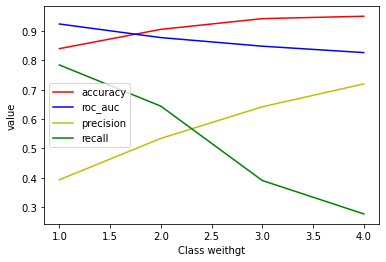

accuracy: 4 0.9501204098958519
roc_auc: 1 0.9237192367452158
precision: 4 0.7197087150575523


In [23]:
#class weight
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
cross = []
l_acc = []
l_roc = []
l_p = []
l_r = []
scoring=["roc_auc","accuracy","precision","recall"]
r = range(1,5)
l = list(r)

for i in l:
    svc = SVC(probability = True,class_weight = {1:1-i/10,0:i/10})
    cross_score =  cross_validate(svc,X,y,cv=5,scoring=scoring)
    for j in list(cross_score.keys()):
        if j == 'test_accuracy':
            l_acc.append(cross_score[j].mean())
        elif j == 'test_roc_auc':
            l_roc.append(cross_score[j].mean())
        elif j == 'test_precision':
            l_p.append(cross_score[j].mean())
        elif j == 'test_recall':
            l_r.append(cross_score[j].mean())
            
plt.plot(r,l_acc,color='r', label="accuracy")
plt.plot(r,l_roc,color='b', label="roc_auc")
plt.plot(r,l_p,color='y', label="precision")
plt.plot(r,l_r,color='g', label="recall")
plt.xlabel('Class weithgt')
plt.ylabel("value")
plt.legend()
plt.show()


print("accuracy:",l[l_acc.index(max(l_acc))],max(l_acc))
print("roc_auc:",l[(l_roc.index(max(l_roc)))],max(l_roc))
print("precision:",l[(l_p.index(max(l_p)))],max(l_p))

In [24]:
X = X_record
y = y_record
X = X[l_gene_u]

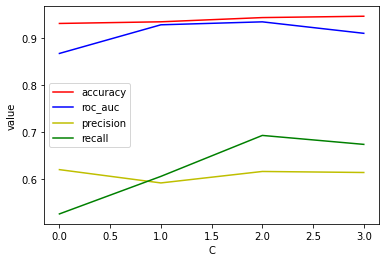

accuracy: 3 0.9466178809293204
roc_auc: 2 0.9347144353104442
precision: 0 0.6207367795603089


In [25]:
#C
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
cross = []
l_acc = []
l_roc = []
l_p = []
l_r = []
scoring=["roc_auc","accuracy","precision","recall"]
r = range(0,4)
l = list(r)

for i in l:
    svc = SVC(C=10**i,probability = True,class_weight = {1:0.75,0:0.25})
    cross_score =  cross_validate(svc,X,y,cv=5,scoring=scoring)
    for j in list(cross_score.keys()):
        if j == 'test_accuracy':
            l_acc.append(cross_score[j].mean())
        elif j == 'test_roc_auc':
            l_roc.append(cross_score[j].mean())
        elif j == 'test_precision':
            l_p.append(cross_score[j].mean())
        elif j == 'test_recall':
            l_r.append(cross_score[j].mean())
            
plt.plot(r,l_acc,color='r', label="accuracy")
plt.plot(r,l_roc,color='b', label="roc_auc")
plt.plot(r,l_p,color='y', label="precision")
plt.plot(r,l_r,color='g', label="recall")
plt.xlabel('C')
plt.ylabel("value")
plt.legend()
plt.show()

print("accuracy:",l[l_acc.index(max(l_acc))],max(l_acc))
print("roc_auc:",l[(l_roc.index(max(l_roc)))],max(l_roc))
print("precision:",l[(l_p.index(max(l_p)))],max(l_p))

C:\Users\HUAWEI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HUAWEI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HUAWEI\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


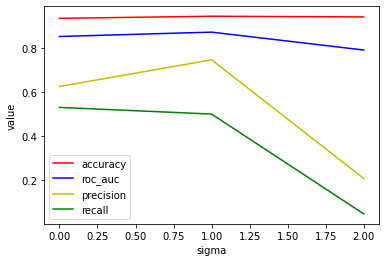

accuracy: 1 0.9455242673171431
roc_auc: 1 0.8731414720847894
precision: 1 0.7471617069062324


In [30]:
#sigma
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
cross = []
l_acc = []
l_roc = []
l_p = []
l_r = []
scoring=["roc_auc","accuracy","precision","recall"]
r = range(0,3)
l = list(r)

for i in l:
    svc = SVC(gamma = 10**i,C=1,probability = True,class_weight = {1:0.75,0:0.25})
    cross_score =  cross_validate(svc,X,y,cv=5,scoring=scoring)
    for j in list(cross_score.keys()):
        if j == 'test_accuracy':
            l_acc.append(cross_score[j].mean())
        elif j == 'test_roc_auc':
            l_roc.append(cross_score[j].mean())
        elif j == 'test_precision':
            l_p.append(cross_score[j].mean())
        elif j == 'test_recall':
            l_r.append(cross_score[j].mean())
            
plt.plot(r,l_acc,color='r', label="accuracy")
plt.plot(r,l_roc,color='b', label="roc_auc")
plt.plot(r,l_p,color='y', label="precision")
plt.plot(r,l_r,color='g', label="recall")
plt.xlabel('sigma')
plt.ylabel("value")
plt.legend()
plt.show()

print("accuracy:",l[l_acc.index(max(l_acc))],max(l_acc))
print("roc_auc:",l[(l_roc.index(max(l_roc)))],max(l_roc))
print("precision:",l[(l_p.index(max(l_p)))],max(l_p))

### 5. model evaluation

In [20]:
X = X_record
y = y_record
X = X[l_gene_u]

In [21]:
from sklearn.svm import SVC
from sklearn import metrics
#training model
svc = SVC(gamma=1,C=1,probability = True,class_weight={0:0.25,1:0.75})
svc.fit(X,y)
y_pred0= svc.predict(X)
y_predprob0= svc.predict_proba(X)[:,1]
#accuracy
print("Training Accuracy : %.4g" % metrics.accuracy_score(y, y_pred0))

Training Accuracy : 0.9608


In [22]:
import joblib
joblib.dump(svc, "NRI_DC_model.m")#save the model

['NRI_DC_model.m']

In [23]:
#import joblib
#svc = joblib.load("NRI_DC_model.m")

In [24]:
from sklearn import metrics

In [17]:
#precision and recall
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred0, labels=None, sample_weight=None)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
recall = cm[1,1]/(cm[1,0]+cm[1,1])
print("precision: {}".format(precision))
print("recall: {}".format(recall))

precision: 0.7225130890052356
recall: 0.5227272727272727


In [18]:
#ROC
def ColorGenerate(num):
    import random
    color_list = []
    for i in range(num):
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        color_list.append(color[0])
    return color_list

def ROC(y, y_predprob,name,color,figure=False,path= None):
    auroc = []
    #------ROC----------
    from sklearn.metrics import roc_curve, auc 
    import random
    # Compute ROC curve and ROC area for each class
    #Plot
    plt.figure()
    plt.rc('font',size=20)
    lw = 2
    plt.figure(figsize=(10,10))
    if len(y)==1:
        y_train = y[0]
        y_predprob0 = y_predprob[0]
        fpr0,tpr0,threshold0 = roc_curve(y_train, y_predprob0)
        roc_auc0 = auc(fpr0,tpr0)
        auroc.append(roc_auc0)
        print("AUROC Score: %f" % metrics.roc_auc_score(y_train, y_predprob0))
        plt.plot(fpr0, tpr0, color=color[0],lw=lw, label='(AUROC=%.4f) %s'%(roc_auc0,name[0]))
    else:
        for i in range(len(y)):
            y_train = y[i]
            y_predprob0 = y_predprob[i]
            fpr0,tpr0,threshold0 = roc_curve(y_train, y_predprob0)
            roc_auc0 = auc(fpr0,tpr0) 
            auroc.append(roc_auc0)
            print("AUROC Score: %f" % metrics.roc_auc_score(y_train, y_predprob0))
            plt.plot(fpr0, tpr0, color=color[i],lw=lw, label='(AUROC=%.4f) %s'%(roc_auc0,name[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ')
    plt.legend(loc="lower right")
    if figure:
        plt.savefig(path,dpi=600,bbox_inches='tight')
    plt.show()
    return auroc
#PRC
def PRC(y, y_predprob, name,color,figure=False,path= None):
    #train
    from sklearn.metrics import precision_recall_curve,average_precision_score,auc
    import random
    # PRC  plot
    plt.figure(figsize=(10,10))
    plt.rc('font',size=20)
    # precision, recall
    if len(y)==1:
        y_train = y[0]
        y_predprob0 = y_predprob[0]
        precision0, recall0,_ = precision_recall_curve(y_train,y_predprob0)
        area0 = auc(recall0, precision0)
        print("AUPRC Score: %f" % area0)
        plt.step(recall0, precision0, color=color[0], label= name[0])
    else:
        for i in range(len(y)):
            y_train = y[i]
            y_predprob0 = y_predprob[i]
            precision0, recall0,_ = precision_recall_curve(y_train,y_predprob0)
            area0 = auc(recall0, precision0)
            print("AUPRC Score: %f" % area0)
            plt.step(recall0, precision0, color=color[i], label= name[i])
    plt.plot([0, 1], [1, 0], color='m', linestyle='--')
    plt.title('PR curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curves')
    plt.legend(loc='lower right')
    if figure:
        plt.savefig(path,dpi=600,bbox_inches='tight')
    plt.show()

AUROC Score: 0.960963


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

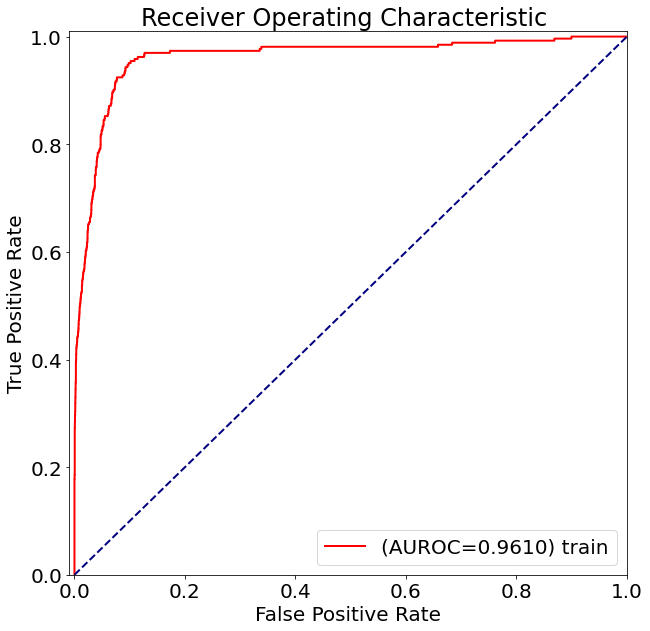

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUPRC Score: 0.730973


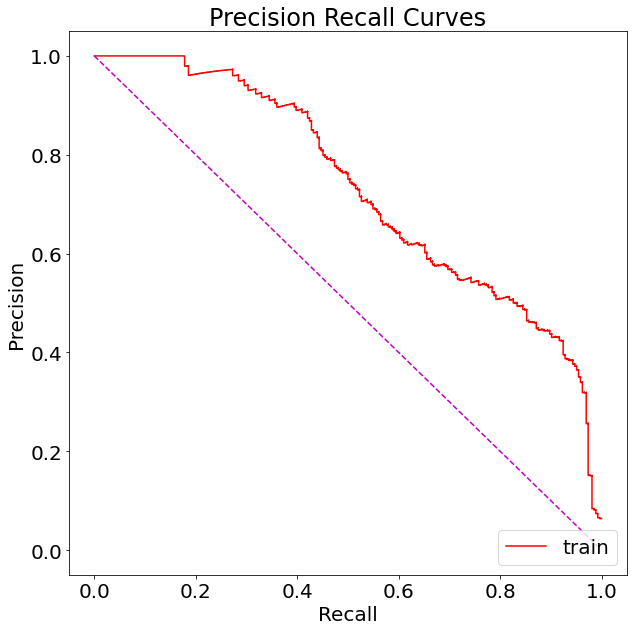

In [19]:
#ROC and PR plot for training
color = ["red"]
path1 = 'Figure_train_DC_NRI_ROC.eps'
auroc = ROC([y], [y_predprob0],name = ["train"],color=color,figure=True,path= path1)
path2 = 'Figure_train_DC_NRI_PR.eps'
PRC([y], [y_predprob0],name = ["train"],color=color,figure=True,path=path2)
result = pd.DataFrame({"pred": y_pred0,"prob":y_predprob0})
result.to_csv("NRI_DC_train_result.csv")

In [20]:
X = X_record
y = y_record
X = X[l_gene_u]

### 6. Permutation Importance

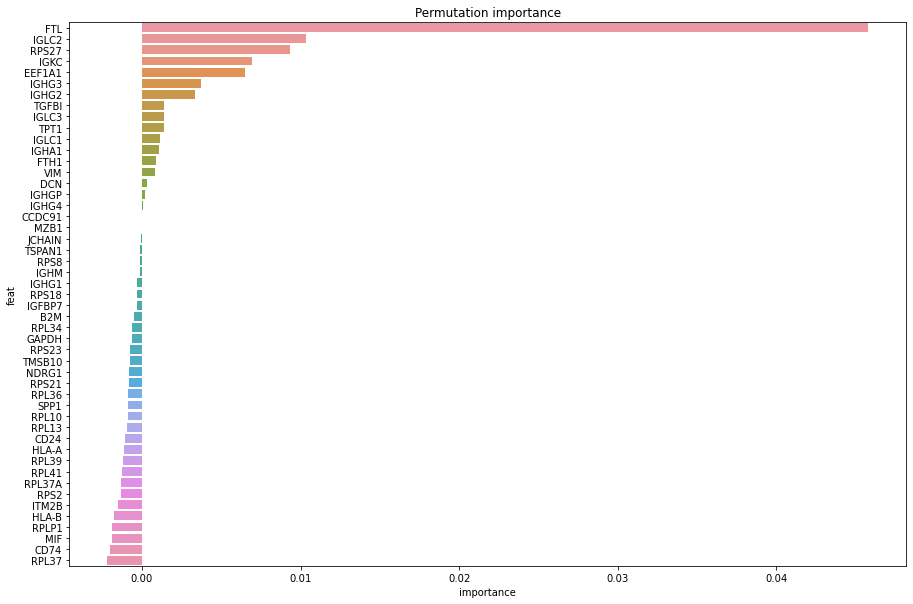

In [98]:
import seaborn as sns
from sklearn.inspection import permutation_importance
result = permutation_importance(svc,X,y)
featImp = pd.DataFrame({"feat":list(l_gene_u), "importance":result.importances_mean.tolist()})
featImp = featImp.sort_values('importance',ascending = False)
plt.figure(figsize=[15,10])
plt.rc('font',size=10)
plt.title("Permutation importance")
sns.barplot(x = 'importance', y = 'feat',data = featImp[:len(l_gene_u)],orient='h')
plt.savefig('Figure2_NRI'+'.eps',dpi=600,bbox_inches='tight')
plt.show()

In [100]:
l_gene_permu = []
for i in range(len(result.importances_mean.tolist())):
    value = result.importances_mean.tolist()[i]
    if value>0:
        l_gene_permu.append(list(l_gene_u)[i])
print(l_gene_permu)

['TGFBI', 'TPT1', 'FTL', 'IGHG4', 'IGKC', 'IGLC1', 'EEF1A1', 'IGLC3', 'IGHGP', 'IGLC2', 'DCN', 'IGHG2', 'RPS27', 'VIM', 'IGHG3', 'FTH1', 'IGHA1']


### 7. Independent test(a_3) and spatial plot for all samples

#### (1) prediction result

In [25]:
from bunch import Bunch
sample = ["a_15","a_3","b_1","b_18"]
#X_list = []
#y_list = []
#Gene = []
L_data2 = Bunch()
L_bartls = Bunch()
l_y = []
l_y_pred = []
l_y_predprob = []
check = True
l_check = []
accurancy = []
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#load data
for i in range(len(sample)):
    #load y
    path = 'result/'+sample[i]+'_annotation.csv'
    data = pd.read_csv(path)
    c = data.shape[0]
    #load X
    path = "result/"+sample[i]+"_matrix.csv"
    X_data = pd.read_csv(path)
    l_gene = X_data["Unnamed: 0"]
    #check whether all the genes are in the intersection of genes in the training sample
    for j in l_gene_u:
        if j in l_gene.tolist():
            continue
        else:
            check = False
            print(j)
            break
    l_check.append(check)
    if not check:
        print("not enough gene for sample {}".format(sample[i]))
        check = True
        continue
    #Adjust the barcode for X
    bar = X_data.columns[1:]
    l_bar=[]
    for j in bar:
        j=str(j).replace("X","")
        l_bar.append(j)
    a = X_data.shape[0]
    b = X_data.shape[1]-1
    X_data = np.array(X_data[bar])
    #normalization
    X_scaler = scaler.fit(X_data)                                   
    X_data = X_scaler.transform(X_data)    
    #reconstruct X
    X_data = pd.DataFrame(X_data.T, columns = l_gene, index = l_bar)
    #adjust the barcode for y
    D1 = dict()
    key = []
    for l in range(c):
        x = '-'+str(i)
        key1 = data['Unnamed: 0'][l]
        value1 = data['TLS_2_cat_annot'][l]
        key1 = str(key1).replace('-1','.1')
        key.append(key1)
        D1[key1] = value1
    L1 = list()
    for j in l_bar:
        if j in key:
            tls = D1[j]
        else:
            tls = 'NO_TLS'
        L1.append(tls)
    print(sample[i])
    #transform to 0,1
    y_data = transformation(L1)
    y_data = y_data.ravel()
    l_y.append(y_data)
    #fit model
    X_data = X_data[l_gene_u]
    y_pred1= svc.predict(X_data)
    y_predprob1= svc.predict_proba(X_data)[:,1]
    l_y_pred.append(y_pred1)
    l_y_predprob.append(y_predprob1)
    print("Testing Accuracy : %.4g" % metrics.accuracy_score(y_data, y_pred1))
    accurancy.append(metrics.accuracy_score(y_data, y_pred1))
    data1 = pd.DataFrame(y_pred1)
    data1 = pd.DataFrame(data1.values, index = l_bar)
    #add position information
    path2 = 'position/'+sample[i]+'_positions_list.csv'
    data2 = pd.read_csv(path2)
    data2 = data2[['barcodes','X','Y']]
    data2 = pd.DataFrame(data2.values.T,index = ['barcodes','X','Y'])
    l_barcodes2 = data2.loc['barcodes'].tolist()
    l_barcodes3=[]
    for k in l_bar:
        index = k.find("_")
        word = k[index+1:]
        word = word.replace(".","-")
        l_barcodes3.append(word)
    data1.index = l_barcodes3
    data2 = pd.DataFrame(data2.values,columns = data2.loc['barcodes'])
    data2.index = ['barcodes','X','Y']
    #connect position and annotation
    D_tls = {}
    for key in l_barcodes3:
        D_tls[key] = data1.loc[key]
    l_bartls = []
    for bar in l_barcodes2:
        if bar in l_barcodes3:
            l_bartls.append(int(D_tls[bar]))
        else:
            l_bartls.append(-1)
    L_data2[sample[i]] = data2
    L_bartls[sample[i]]=l_bartls

a_15
35
Testing Accuracy : 0.9423
a_3
33
Testing Accuracy : 0.9847
b_1
153
Testing Accuracy : 0.9635
b_18
78
Testing Accuracy : 0.9275


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUROC Score: 0.814808
AUROC Score: 0.992457
AUROC Score: 0.975879
AUROC Score: 0.901781


<Figure size 432x288 with 0 Axes>

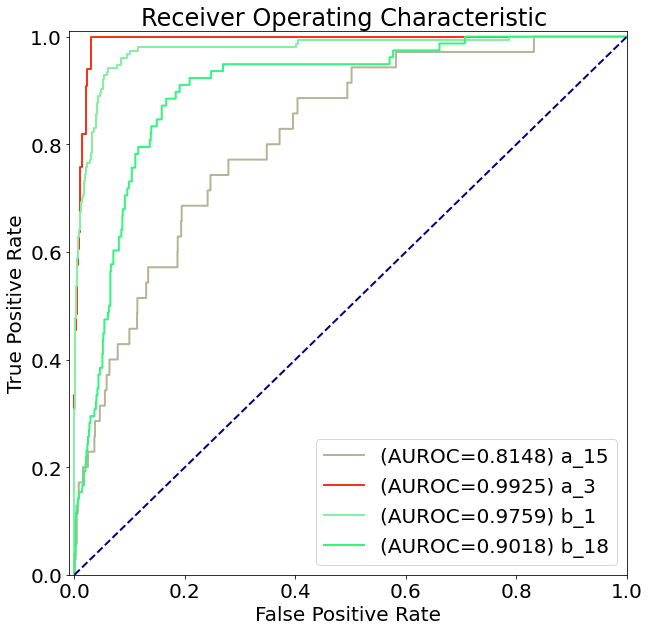

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


AUPRC Score: 0.103317
AUPRC Score: 0.766230
AUPRC Score: 0.855267
AUPRC Score: 0.401299


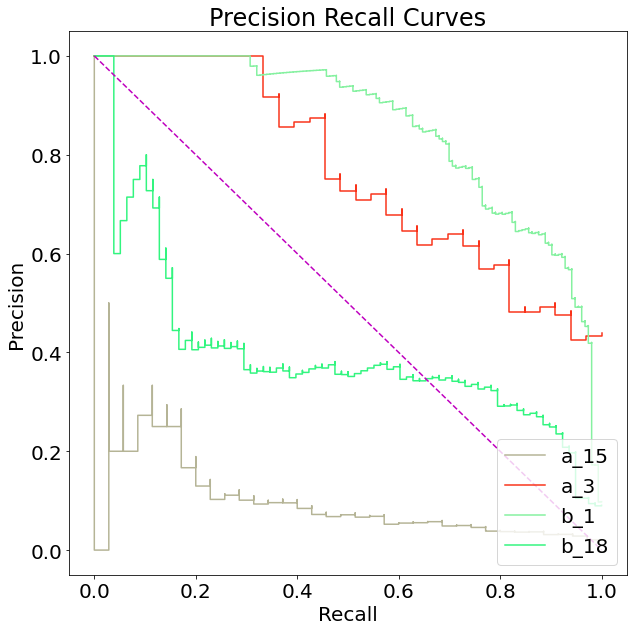

In [22]:
#ROC and PRC
#number = len(l_y)
#color = ColorGenerate(number)
color = ['#B5B496', '#F93219', '#85F1A0', '#32F57F']
path1 = 'Figure_test_DC_NRI_ROC.eps'
auroc = ROC(l_y, l_y_predprob,name = sample,color=color,figure=True,path= path1)
path2 = 'Figure_test_DC_NRI_PR.eps'
PRC(l_y, l_y_predprob,name = sample,color=color,figure=True,path= path2)
df = pd.DataFrame({"sample":sample,"accurancy":accurancy,"auroc":auroc})
df.to_csv("NRI_DC_test_performance.csv")

In [26]:
#Precision and Recall
sample = ["a_15","a_3","b_1","b_18"]
for i in range(len(sample)):
    print(sample[i])
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(l_y[i], l_y_pred[i], labels=None, sample_weight=None)
    precision = cm[1,1]/(cm[1,1]+cm[0,1])
    recall = cm[1,1]/(cm[1,0]+cm[1,1])
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))

a_15
precision: 0.10891089108910891
recall: 0.3142857142857143
a_3
precision: 0.8666666666666667
recall: 0.3939393939393939
b_1
precision: 0.8106060606060606
recall: 0.6993464052287581
b_18
precision: 0.4090909090909091
recall: 0.23076923076923078


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


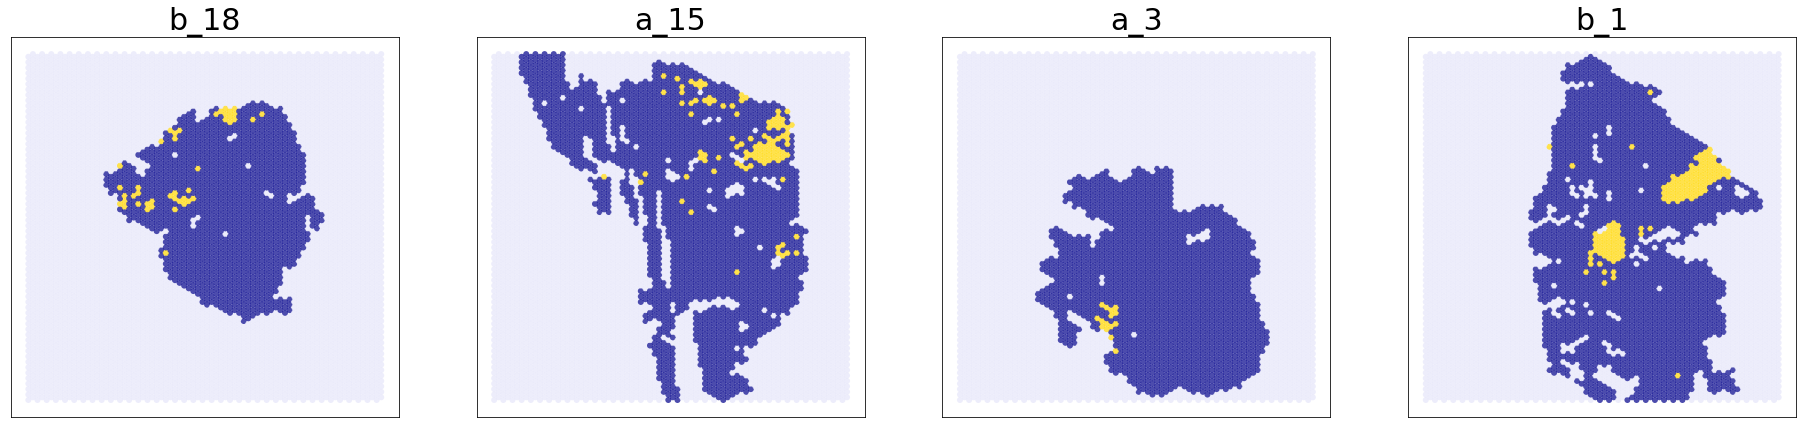

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(32,7))
import matplotlib as mpl
cmp = mpl.colors.ListedColormap(['lavender','darkblue','gold'])
norm = mpl.colors.BoundaryNorm([-1,0,1,2], cmp.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmp)
for i in range(len(sample)):
    y = i%4
    name = sample[i-1]
    df=L_data2[name]
    ax[y].set_title(name, fontsize=30)
    ax[y].get_xaxis().set_visible(False)
    ax[y].get_yaxis().set_visible(False)
    ax[y].scatter(np.array(df.loc['X'].tolist()),np.array(df.loc['Y'].tolist()), c=L_bartls[name], edgecolors='none', cmap=cmp, norm=norm,alpha=0.7)
plt.savefig('Figure4A_NRI_DC'+'.eps',dpi=600,bbox_inches='tight')#保存文件在指定文件夹下很方便
plt.show()

#### (2) plot the correct answer in spatial

In [28]:
from bunch import Bunch
sample = ["a_15","a_3","b_1","b_18"]
#X_list = []
#y_list = []
#Gene = []
L_data2 = Bunch()
L_bartls = Bunch()
l_y = []
l_y_pred = []
l_y_predprob = []
check = True
l_check = []
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#load data
for i in range(len(sample)):
    path = 'result/'+sample[i]+'_annotation.csv'
    data = pd.read_csv(path)
    c = data.shape[0]
    path = "result/"+sample[i]+"_matrix.csv"
    X_data = pd.read_csv(path)
    l_gene = X_data["Unnamed: 0"]
    for j in l_gene_u:
        if j in l_gene.tolist():
            continue
        else:
            check = False
            break
    l_check.append(check)
    if not check:
        print("not enough gene for sample {}".format(sample[i]))
        continue
    #Gene.append(l_gene)
    bar = X_data.columns[1:]
    l_bar=[]
    for j in bar:
        j=str(j).replace("X","")
        l_bar.append(j)
    a = X_data.shape[0]
    b = X_data.shape[1]-1
    #X_list.append(X_data)
    D1 = dict()
    key = []
    for l in range(c):
        x = '-'+str(i)
        key1 = data['Unnamed: 0'][l]
        value1 = data['TLS_2_cat_annot'][l]
        key1 = str(key1).replace('-1','.1')
        key.append(key1)
        D1[key1] = value1
    L1 = list()
    for j in l_bar:
        if j in key:
            tls = D1[j]
        else:
            tls = 'NO_TLS'
        L1.append(tls)
    print(sample[i])
    y_data = transformation(L1)
    y_data = y_data.ravel()
    l_y.append(y_data)
    #y_list.append(y_data)
    #fit model
    data1 = pd.DataFrame(y_data)
    data1 = pd.DataFrame(data1.values, index = l_bar)
    #position
    path2 = 'position/'+sample[i]+'_positions_list.csv'
    data2 = pd.read_csv(path2)
    data2 = data2[['barcodes','X','Y']]
    data2 = pd.DataFrame(data2.values.T,index = ['barcodes','X','Y'])
    l_barcodes2 = data2.loc['barcodes'].tolist()
    l_barcodes3=[]
    for k in l_bar:
        index = k.find("_")
        word = k[index+1:]
        word = word.replace(".","-")
        l_barcodes3.append(word)
    data1.index = l_barcodes3
    data2 = pd.DataFrame(data2.values,columns = data2.loc['barcodes'])
    data2.index = ['barcodes','X','Y']
    #connect position and annotation
    D_tls = {}
    for key in l_barcodes3:
        D_tls[key] = data1.loc[key]
    l_bartls = []
    for bar in l_barcodes2:
        if bar in l_barcodes3:
            l_bartls.append(int(D_tls[bar]))
        else:
            l_bartls.append(-1)
   # plt.axis([-0.1, 78, -0.1, 127])
    #plt.scatter(np.array(data2.loc['X'].tolist()),np.array(data2.loc['Y'].tolist()), c=l_bartls, edgecolors='none', cmap=cmp, norm=norm,alpha=0.7)
    #plt.show()
    L_data2[sample[i]] = data2
    L_bartls[sample[i]]=l_bartls

a_15
35
a_3
33
b_1
153
b_18
78


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


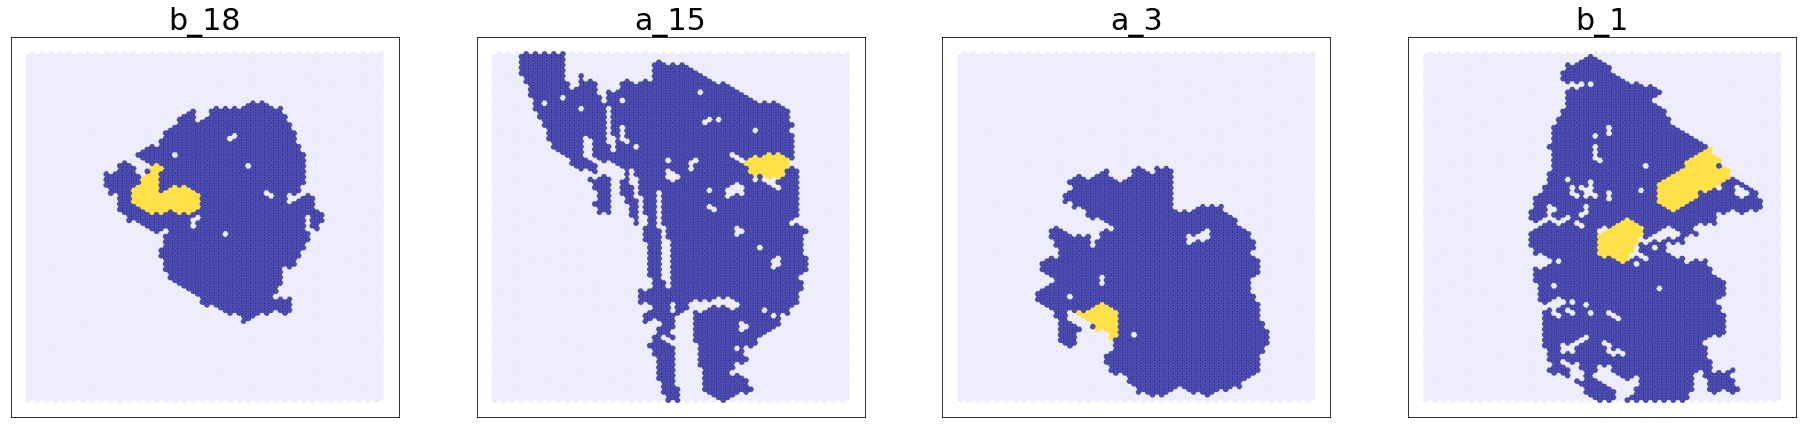

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(32,7))
import matplotlib as mpl
cmp = mpl.colors.ListedColormap(['lavender','darkblue','gold'])
norm = mpl.colors.BoundaryNorm([-1,0,1,2], cmp.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmp)
for i in range(len(sample)):
    y = i%4
    name = sample[i-1]
    df=L_data2[name]
    ax[y].set_title(name, fontsize=30)
    ax[y].get_xaxis().set_visible(False)
    ax[y].get_yaxis().set_visible(False)
    ax[y].scatter(np.array(df.loc['X'].tolist()),np.array(df.loc['Y'].tolist()), c=L_bartls[name], edgecolors='none', cmap=cmp, norm=norm,alpha=0.7)
plt.savefig('Figure4B_NRI'+'.eps',dpi=600,bbox_inches='tight')
plt.show()